In [1]:
import warnings; warnings.simplefilter('ignore')

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import edward as ed
from edward.models import Normal, Empirical
import pystan

%matplotlib inline

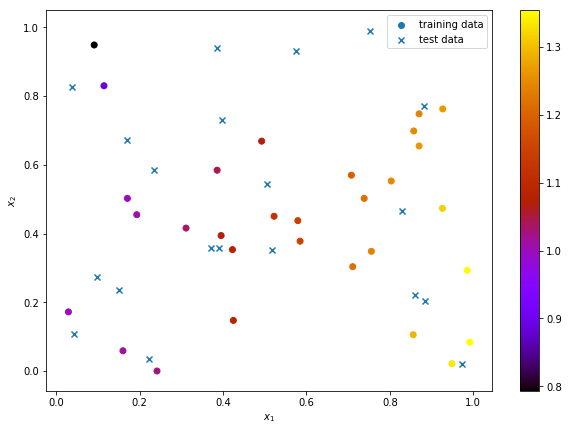

In [3]:
#f = lambda x: np.sqrt( x[0]**2 + x[1]**2 )
f = lambda x: np.sqrt( np.sin(x[0]**2) + np.cos(x[1]**2 ))

N_total = 50
N_train = 30
X = np.random.ranf(size=(N_total,2))
Y = np.array( list(map(f, X)) ).reshape(-1,1)

X_train = X[:N_train, :]
Y_train = Y[:N_train, :]

X_test = X[N_train:, :]
Y_test = Y[N_train:, :]

N, D = X_train.shape

fig = plt.figure(figsize=(10,7))
p = plt.scatter(*X_train.T, c=Y_train, cmap='gnuplot', label='training data')
plt.colorbar(p)
plt.scatter(*X_test.T, marker='x', label='test data')
plt.xlabel('$x_1$'), plt.ylabel('$x_2$')
plt.legend();

<h3>Non-Bayesian Neural Network and Bayesian Neural Network in Tensorflow and Edward</h3>

In [4]:
def nn(X_train, Y_train, size_l1=5, size_l2=1, lam=0.01, iterations=10000, tol=5e-5):
    _, D = X_train.shape
    
    w1 = tf.Variable( tf.random_normal([D, size_l1]) )
    w2 = tf.Variable( tf.random_normal([size_l1, size_l2]) )
    b1 = tf.Variable( tf.random_normal([size_l1]) )
    b2 = tf.Variable( tf.random_normal([size_l2]) )
    
    X = tf.placeholder(tf.float32, [None, D])
    Y = tf.placeholder(tf.float32)
    Y_pred = tf.matmul(tf.tanh(tf.matmul(X, w1) + b1), w2) + b2
    
    loss = tf.reduce_mean( tf.losses.mean_squared_error(Y, Y_pred) ) \
            + lam* (tf.nn.l2_loss(w1) + tf.nn.l2_loss(w2))
    optimizer = tf.train.AdamOptimizer().minimize(loss)
    
    with tf.Session() as sess:
        sess.run( tf.global_variables_initializer() )
        _, error = sess.run( [optimizer, loss], feed_dict={X:X_train, Y:Y_train} )
        _, error2 = sess.run( [optimizer, loss], feed_dict={X:X_train, Y:Y_train} )
        i = 0
        while np.fabs( (error-error2)/error ) > tol and i < iterations:
            error = error2
            _, error2 = sess.run( [optimizer, loss], feed_dict={X:X_train, Y:Y_train} )
            i += 1
        
        print( 'converged after {} iterations, MSE: {}'.format(i, error) )
        w1, w2, b1, b2 = sess.run( [w1, w2, b1, b2] )
        
    return w1, w2, b1, b2



def bayesian_nn(X_train, Y_train, size_l1=5, size_l2=1):
    _, D = X_train.shape

    w1 = Normal(loc=tf.zeros([D, size_l1]), scale=tf.ones([D, size_l1]))
    w2 = Normal(loc=tf.zeros([size_l1, size_l2]), scale=tf.ones([size_l1, size_l2]))
    b1 = Normal(loc=tf.zeros(size_l1), scale=tf.ones(size_l1))
    b2 = Normal(loc=tf.zeros(size_l2), scale=tf.ones(size_l2))

    X = tf.placeholder(tf.float32, [None, D])
    Y = Normal(loc=tf.matmul(tf.tanh(tf.matmul(X, w1) + b1), w2) + b2, scale=0.1)

    qw1 = Normal( loc=tf.Variable(tf.zeros([D, size_l1])), 
                 scale=tf.nn.softplus(tf.Variable(tf.zeros([D, size_l1]))) )
    qw2 = Normal( loc=tf.Variable(tf.zeros([size_l1, size_l2])), 
                 scale=tf.nn.softplus(tf.Variable(tf.zeros([size_l1, size_l2]))) )
    qb1 = Normal( loc=tf.Variable(tf.zeros(size_l1)),  
                 scale=tf.nn.softplus(tf.Variable(tf.zeros(size_l1))) )
    qb2 = Normal( loc=tf.Variable(tf.zeros(size_l2)),  
                 scale=tf.nn.softplus(tf.Variable(tf.zeros(size_l2))) )

    inference = ed.KLqp( {w1: qw1, b1: qb1, w2: qw2, b2: qb2}, data={X:X_train, Y:Y_train} )
    inference.run(n_iter=2000)
    
    #samples = 1000
    #qw1 = Empirical( params=tf.Variable(tf.zeros([samples, D, size_l1]))  )
    #qw2 = Empirical( params=tf.Variable(tf.zeros([samples, size_l1, size_l2])) )
    #qb1 = Empirical( params=tf.Variable(tf.zeros([samples, size_l1])) )
    #qb2 = Empirical( params=tf.Variable(tf.zeros([samples, size_l2])) )
    
    ##inference = ed.Gibbs( {w1: qw1, b1: qb1, w2: qw2, b2: qb2}, data={X:X_train, Y:Y_train} )
    #inference = ed.HMC( {w1: qw1, b1: qb1, w2: qw2, b2: qb2}, data={X:X_train, Y:Y_train} )
    #inference.run()
    
    
    #print error
    Y_post = ed.copy(Y, {w1: qw1, b1: qb1, w2: qw2, b2: qb2})
    print( 'MSE: {}'.format(
                 ed.evaluate('mean_squared_error', data={X: X_test, Y_post: Y_test})) )
    
    return qw1, qw2, qb1, qb2



def predict(X, w1, w2, b1, b2):
    return np.matmul(np.tanh(np.matmul(X, w1) + b1), w2) + b2

In [5]:
print('non-bayesian prediction')
w1, w2, b1, b2 = nn(X_train, Y_train, size_l1=5, size_l2=1)

pred_non_bayes = predict(X_test, w1, w2, b1, b2)



print('\nbayesian prediction')
qw1, qw2, qb1, qb2 = bayesian_nn(X_train, Y_train, size_l1=5, size_l2=1)

it = 100
pred_bayes = np.zeros((Y_test.shape[0], it))
for i in range(it):
    pred_bayes[:, i] = predict(X_test, qw1.eval(), qw2.eval(), 
                               qb1.eval(),qb2.eval()).reshape(-1)

non-bayesian prediction
converged after 5115 iterations, MSE: 0.005132096819579601

bayesian prediction
2000/2000 [100%] ██████████████████████████████ Elapsed: 5s | Loss: -3.313  

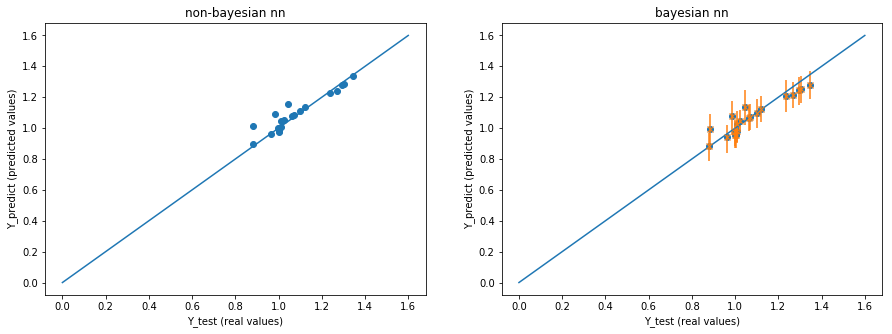

In [6]:
pred_bayes_mean = np.percentile(pred_bayes, 50, axis=1)
pred_bayes_h = np.percentile(pred_bayes, 90, axis=1)
pred_bayes_l = np.percentile(pred_bayes, 10, axis=1)

#plot
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(121)
ax.scatter(Y_test, pred_non_bayes)
ax.plot(np.linspace(0,1.6,20), np.linspace(0,1.6,20))
ax.set_xlabel('Y_test (real values)'), ax.set_ylabel('Y_predict (predicted values)')
ax.set_title('non-bayesian nn')

ax = fig.add_subplot(122)
ax.scatter(Y_test, pred_bayes_mean)
ax.plot(np.linspace(0,1.6,20), np.linspace(0,1.6,20))
ax.errorbar(Y_test, pred_bayes_mean, 
             yerr=[pred_bayes_h-pred_bayes_mean, pred_bayes_mean-pred_bayes_l], 
             fmt='x')
ax.set_xlabel('Y_test (real values)'), ax.set_ylabel('Y_predict (predicted values)')
ax.set_title('bayesian nn');

<h3>Prediction performance on an outlier</h3>

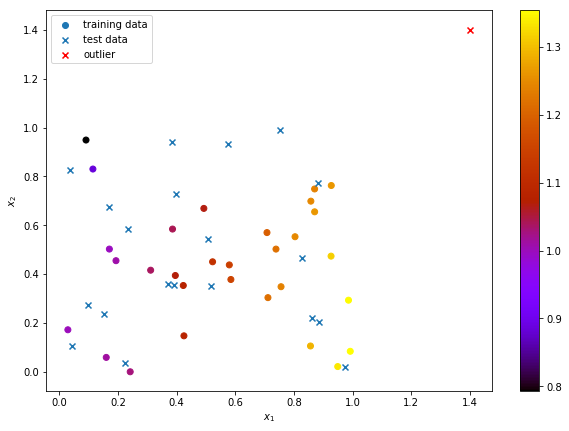

In [7]:
#add an outlier to X_test
out = [1.4, 1.4]
X_test_outlier = np.concatenate((X_test, [out,]), axis=0)
Y_test_outlier = np.concatenate((Y_test, [[f(out)]]), axis=0)



    
fig = plt.figure(figsize=(10,7))
p = plt.scatter(*X_train.T, c=Y_train, cmap='gnuplot', label='training data')
plt.colorbar(p)
plt.scatter(*X_test.T, marker='x', label='test data')
plt.scatter(*X_test_outlier[-1].T, c='r', marker='x', label='outlier')
plt.xlabel('$x_1$'), plt.ylabel('$x_2$')
plt.legend();

In [8]:
#predict outlier performance with non-bayesian nn and bayesian nn
pred_non_bayes = predict(X_test_outlier, w1, w2, b1, b2)


it = 100
pred_bayes = np.zeros((Y_test_outlier.shape[0], it))
for i in range(it):
    pred_bayes[:, i] = predict(X_test_outlier, qw1.eval(), qw2.eval(), 
                               qb1.eval(),qb2.eval()).reshape(-1)

pred_bayes_mean = np.percentile(pred_bayes, 50, axis=1)
pred_bayes_h = np.percentile(pred_bayes, 90, axis=1)
pred_bayes_l = np.percentile(pred_bayes, 10, axis=1)

<h3>Bayesian NN in Stan - Posterior weights are sampled</h3>

In [9]:
nn_stan = """
data {
   int<lower=0> N;
   int<lower=0> D;
   int<lower=0> H; // size of hidden layer
   matrix[N,D] X;
   vector[N] t;
}
parameters {
   matrix[D,H] W1;
   vector[H] wb1; // bias of hidden nodes
   vector[H] W2;
   real wb2; // bias of outputs
   real<lower=0> sigma;
}
model {
   // Priors
   to_vector(W1) ~ normal(0, 0.5);
   wb1 ~ normal(0, 0.5);
   W2 ~ normal(0, 0.5);
   wb2 ~ normal(0, 0.5);
   sigma ~ cauchy(0, 0.5);

   // Likelihood
   {
     matrix[N,H] ah;

     ah = tanh(X * W1 + rep_matrix(wb1', N));
     t ~ normal(ah * W2 + wb2, sigma);
   }
}"""
model = pystan.StanModel(model_code=nn_stan)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_37544bbf143c17029f9657cf69306329 NOW.


In [10]:
N, D = X_train.shape
data_dict = {'N':N, 'D':D, 'H':5, 'X':X_train, 't':Y_train.reshape(-1)}
sample = model.sampling(data=data_dict)

w1 = sample.extract('W1')['W1']
b1 = sample.extract('wb1')['wb1']
w2 = sample.extract('W2')['W2']
b2 = sample.extract('wb2')['wb2']
n_samples = len(w1)

print(w1.shape, b1.shape, w2.shape, b2.shape)

pred_sample_nn = np.zeros( (len(X_test_outlier), n_samples) )
for s in range(n_samples):
    pred_sample_nn[:,s] = predict(X_test_outlier, w1[s], w2[s], b1[s], b2[s])

pred_sample_nn_mean = np.percentile(pred_bayes, 50, axis=1)
pred_sample_nn_h = np.percentile(pred_bayes, 90, axis=1)
pred_sample_nn_l = np.percentile(pred_bayes, 10, axis=1)

(4000, 2, 5) (4000, 5) (4000, 5) (4000,)


<h3>Gaussian Process</h3>

In [11]:
#gaussian process
kernel = lambda x1, x2, l=.7, noise=.1: 2*np.exp(-0.5*np.square((x1-x2)/l).sum()) + noise*np.array_equal(x1,x2)
K_train = [[kernel(x1, x2) for x1 in X_train] for x2 in X_train]

# prediction
K_test = np.array([[kernel(x1, x2, noise=0.) for x1 in X_test_outlier] for x2 in X_test_outlier])
K_train_test = np.array([[kernel(x1, x2, noise=0.) for x1 in X_train] for x2 in X_test_outlier])

pred_gp = np.dot( K_train_test, np.linalg.inv(K_train).dot(Y_train) )
pred_gp_error = K_test - K_train_test.dot( np.linalg.inv(K_train).dot(K_train_test.T) )
pred_gp_error = np.diag(pred_gp_error)

<h3>Plot results</h3>

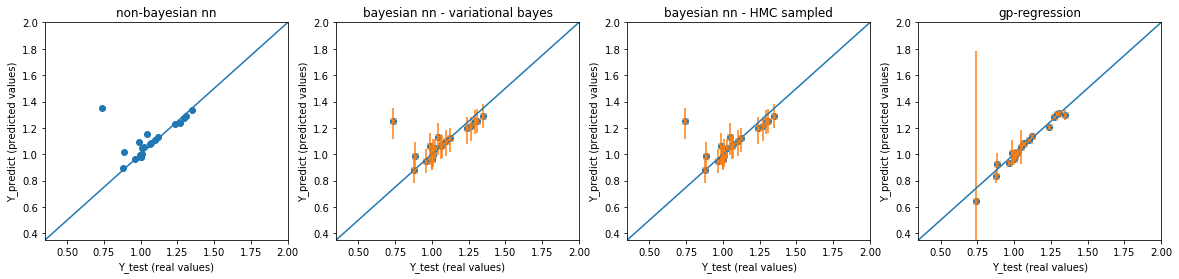

In [12]:
_xlim = [.35,2.0]
_ylim = _xlim


#plot
fig = plt.figure(figsize=(20,4))
ax = fig.add_subplot(141)
ax.scatter(Y_test_outlier, pred_non_bayes)
ax.plot(np.linspace(*_xlim,20), np.linspace(*_xlim,20))
ax.set_xlabel('Y_test (real values)'), ax.set_ylabel('Y_predict (predicted values)')
ax.set_title('non-bayesian nn')
ax.set_xlim(*_xlim), ax.set_ylim(*_ylim)

ax = fig.add_subplot(142)
ax.scatter(Y_test_outlier, pred_bayes_mean)
ax.plot(np.linspace(*_xlim,20), np.linspace(*_xlim,20))
ax.errorbar(Y_test_outlier, pred_bayes_mean, 
             yerr=[pred_bayes_h-pred_bayes_mean, pred_bayes_mean-pred_bayes_l], 
             fmt='x')
ax.set_xlabel('Y_test (real values)'), ax.set_ylabel('Y_predict (predicted values)')
ax.set_title('bayesian nn - variational bayes')
ax.set_xlim(*_xlim), ax.set_ylim(*_ylim)

ax = fig.add_subplot(143)
ax.scatter(Y_test_outlier, pred_sample_nn_mean)
ax.plot(np.linspace(*_xlim,20), np.linspace(*_xlim,20))
ax.errorbar(Y_test_outlier, pred_sample_nn_mean, 
             yerr=[pred_sample_nn_h-pred_sample_nn_mean, pred_sample_nn_mean-pred_sample_nn_l], 
             fmt='x')
ax.set_xlabel('Y_test (real values)'), ax.set_ylabel('Y_predict (predicted values)')
ax.set_title('bayesian nn - HMC sampled')
ax.set_xlim(*_xlim), ax.set_ylim(*_ylim)

ax = fig.add_subplot(144)
ax.scatter(Y_test_outlier, pred_gp)
ax.plot(np.linspace(*_xlim,20), np.linspace(*_xlim,20))
ax.errorbar(Y_test_outlier, pred_gp, 
             yerr=[pred_gp_error, pred_gp_error], 
             fmt='x')
ax.set_xlabel('Y_test (real values)'), ax.set_ylabel('Y_predict (predicted values)')
ax.set_title('gp-regression')
ax.set_xlim(*_xlim), ax.set_ylim(*_ylim)

fig.savefig('modelComparison.pdf', format='pdf')